<a href="https://colab.research.google.com/github/LiadTssf/cloud-project/blob/main/hw2/part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
!pip install firebase

In [2]:
from firebase import firebase
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np


## Functions

In [3]:
# Get data from firebase
def get_data_from_firebase(url, database, data):
    FBconn = firebase.FirebaseApplication(url, None)
    data = FBconn.get(database, data)
    return data

In [4]:
# Function to get set array of onshape documents
def get_documents_set(data):
    documents = set()
    for item in data:
        document = item.get("Document")
        if document is not None:
            documents.add(document)
    return sorted(documents)



# Function to update team member tab content and navigate to it
def update_team_member_content(button):
    selected_projects = [checkbox.description for checkbox in project_checkboxes if checkbox.value]
    users = get_users_by_projects(data, selected_projects)
    global user_checkboxes
    user_checkboxes = [
        widgets.Checkbox(
            value=False,
            description=user,
            style={'description_width': 'initial'},
            layout=widgets.Layout(font_size='20px', width='100%')
        ) for user in users
    ]
    team_member_content.children = [widgets.HTML("<h3 style='font-size: 24px;'>Select Team Member</h3>")] + user_checkboxes + [widgets.HBox([next_button], layout=widgets.Layout(justify_content='center', margin='20px 0 0 0'))]
    tab.selected_index = 1  # Navigate to the "Select Team Member" tab

def next_button_click(button):
    analytics_content.children = (
        [widgets.HTML("<h3 style='font-size: 24px;'>Analytics Content</h3>"),
        graph_type_dropdown,
        widgets.HBox([generate_button], layout=widgets.Layout(justify_content='center', margin='20px 0 0 0'))]
    )
    tab.selected_index = 2  # Navigate to the "Analytics" tab

# Function to get users associated with selected projects
def get_users_by_projects(data, selected_projects):
    users = set()
    for item in data:
        if item.get("Document") in selected_projects:
            users.add(item.get("User"))
    return users


In [5]:

def generate_graph(button):
    # Get current selections from UI elements
    selected_users = [checkbox.description for checkbox in user_checkboxes if checkbox.value]
    selected_projects = [checkbox.description for checkbox in project_checkboxes if checkbox.value]
    graph_type = graph_type_dropdown.value

    # Validate selections and perform graph generation
    if selected_users and selected_projects:
        if graph_type == 'Contribution Breakdown':
            activity = {}
            for item in data:
                user = item.get("User")
                project = item.get("Document")
                if user in selected_users and project in selected_projects:
                    month = int(item.get("Time").split('-')[1])
                    activity.setdefault(user, [0]*12)[month - 1] += 1

            labels = list(activity.keys())
            sizes = np.sum(list(activity.values()), axis=1)
            plt.figure(figsize=(8, 6))
            plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
            plt.title('Contribution Breakdown')
            plt.show()

        elif graph_type == 'Activity Timeline':
            activity = {user: [0]*12 for user in selected_users}
            for item in data:
                user = item.get("User")
                project = item.get("Document")
                if user in selected_users and project in selected_projects:
                    month = int(item.get("Time").split('-')[1])
                    activity[user][month - 1] += 1

            plt.figure(figsize=(10, 6))
            for user, activity_data in activity.items():
                plt.plot(range(1, 13), activity_data, label=user)
            plt.xlabel('Month')
            plt.ylabel('Activity Count')
            plt.title('Activity Timeline')
            plt.legend()
            plt.show()

        elif graph_type == 'Task Distribution':
            tasks = {}
            for item in data:
                user = item.get("User")
                project = item.get("Document")
                if user in selected_users and project in selected_projects:
                    task_type = item.get("Description").split(' ')[0]  # Example extraction
                    tasks.setdefault(user, {}).setdefault(task_type, 0)
                    tasks[user][task_type] += 1

            plt.figure(figsize=(10, 6))
            for task_type in tasks[selected_users[0]]:
                plt.bar(selected_users, [tasks[user].get(task_type, 0) for user in selected_users], label=task_type)
            plt.xlabel('Users')
            plt.ylabel('Count')
            plt.title('Task Types Breakdown')
            plt.legend()
            plt.show()
        elif graph_type == 'Performance Metrics':
            quality_metrics = {user: {'Actions Completed': 0, 'Changes Made': 0, 'Fixes Applied': 0} for user in selected_users}

            for item in data:
                user = item.get("User")
                project = item.get("Document")
                if user in selected_users and project in selected_projects:
                    action = item.get("Description").split(' ')[0]  # Extract action keyword

                    if action in ['Change', 'Edit', 'Fix', 'Update', 'Animate', 'Suppress', 'Create']:
                        quality_metrics[user]['Actions Completed'] += 1

                    if action in ['Change', 'Edit', 'Fix', 'Update', 'Animate', 'Move']:
                        quality_metrics[user]['Changes Made'] += 1

                    if action in ['Fix', 'Unfix']:
                        quality_metrics[user]['Fixes Applied'] += 1

            # Plotting quality metrics
            metrics = ['Actions Completed', 'Changes Made', 'Fixes Applied']
            plt.figure(figsize=(10, 6))
            for metric in metrics:
                plt.bar([user for user in selected_users], [quality_metrics[user].get(metric, 0) for user in selected_users], label=metric)
            plt.xlabel('Users')
            plt.ylabel('Metrics')
            plt.title('Quality and Productivity Metrics')
            plt.legend()
            plt.show()

        else:
            print("Invalid Graph Type selected.")

    else:
        print("Please select at least one user and one project.")

## Main Program

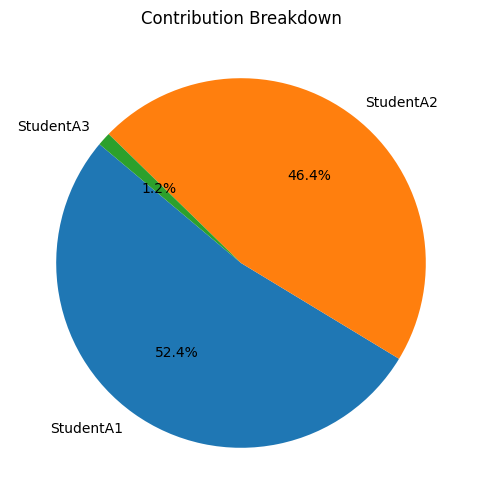

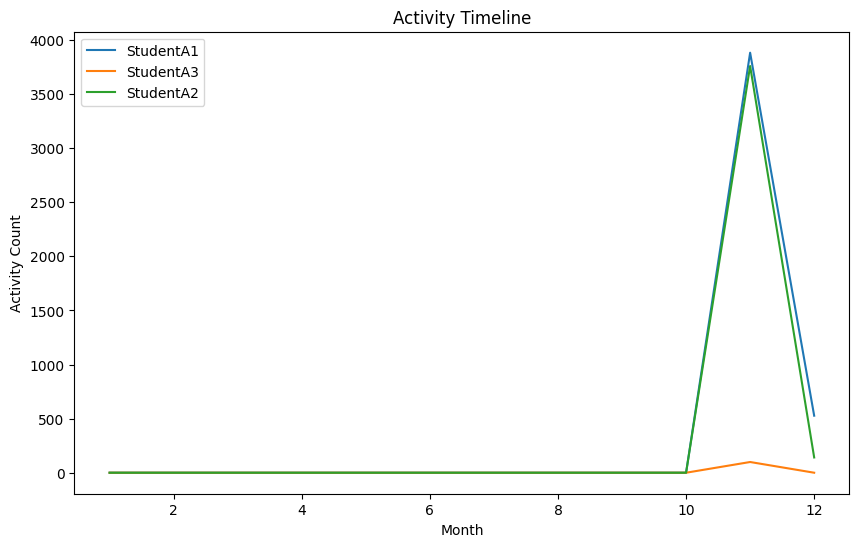

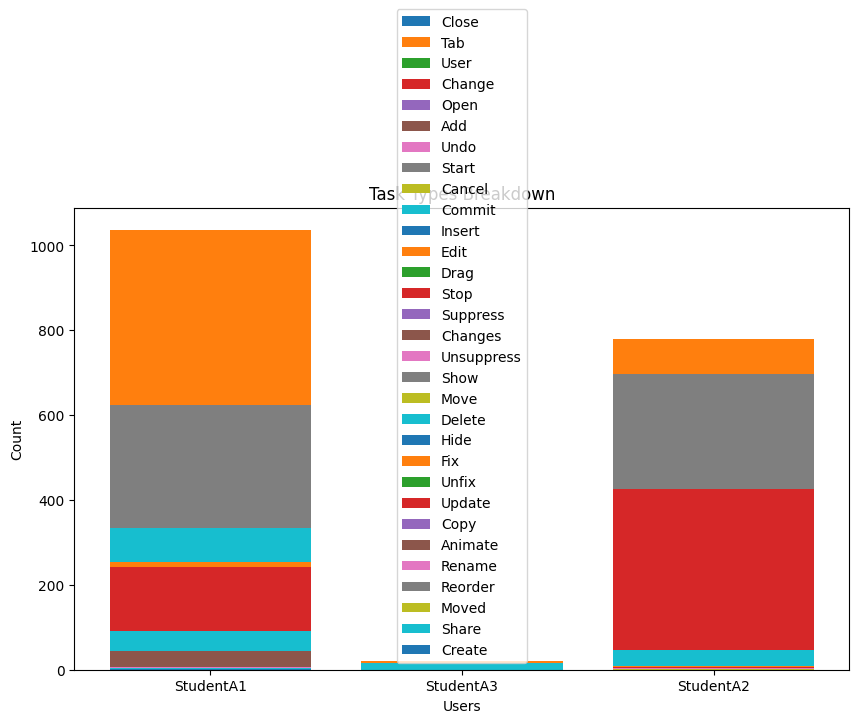

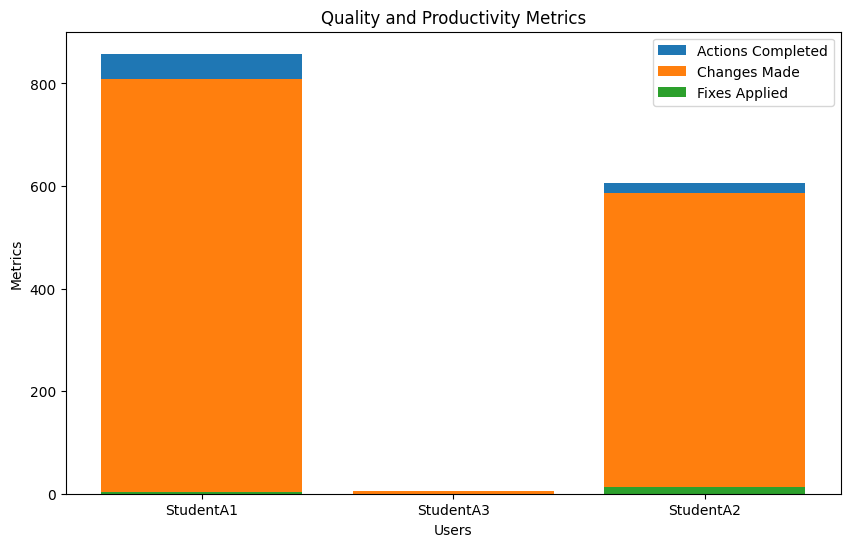

In [6]:


# Fetch data
data = get_data_from_firebase('https://test100000-ccdb4-default-rtdb.asia-southeast1.firebasedatabase.app/', '/team_data', 'data')
data_documents = get_documents_set(data)
#print(data)
# Create CSS styling for the tabs and other elements
style = widgets.HTML("""
    <style>
    body {
        font-family: 'Times New Roman', serif;
      }
    ul {
        padding-left: 20px;
        margin-top: 10px;
        margin-bottom: 10px;
        list-style-type: disc;
        justify_content: between;
    }
    .jupyter-widgets.widget-tab > .p-TabBar .p-TabBar-tab {
        flex: 1 1 var(--jp-widgets-horizontal-tab-width);
    }
    li {
        font-size: 20px !important;
        font-weight: bold;
        margin-bottom: 5px;
        padding: 10px;
        gap: 10px;
    }

    h3 {
        text-decoration: underline;
    }
    span {
        font-size: 20px !important;
    }
    </style>
""")

# Create widgets
title = widgets.HTML(value="<h1 style='font-size: 45px;'>OnShape Analytics Program</h1>", layout=widgets.Layout(margin='0 0 20px 0'))
user_info = widgets.HTML(value="<h3 style='font-size: 24px;'>Logout</h3>")

# Create project checkboxes with increased font size and max width
project_checkboxes = [
    widgets.Checkbox(
        value=False,
        description=str(doc),
        style={'description_width': 'initial'},
        layout=widgets.Layout(font_size='20px', width='100%')
    ) for doc in data_documents if doc is not None
]

update_button = widgets.Button(
    description="Select Projects",
    layout=widgets.Layout(width='150px', height='50px'),
    style={'button_color': 'black', 'font_size': '24px', 'font_weight': 'bold', 'margin-bottom': '10px'}
)

next_button = widgets.Button(
    description="Next",
    layout=widgets.Layout(width='150px', height='50px'),
    style={'button_color': 'black', 'font_size': '24px', 'font_weight': 'bold', 'margin-bottom': '10px'}
)

# Create tabs
tab = widgets.Tab()

update_button.on_click(update_team_member_content)
next_button.on_click(next_button_click)

# Tab contents
analytics_content = widgets.VBox()
team_member_content = widgets.VBox()
projects_content = widgets.VBox(
    [widgets.HTML("<h3 style='font-size: 24px;'>Select Projects</h3>")] +
    project_checkboxes + [widgets.HBox([update_button], layout=widgets.Layout(justify_content='center', margin='20px 0 0 0'))]
)
notifications_content = widgets.VBox([widgets.HTML("<h3 style='font-size: 24px;'>Notifications Content</h3>")])

tab.children = [projects_content, team_member_content, analytics_content, notifications_content]
tab.set_title(0, 'Select Projects')
tab.set_title(1, 'Select Team Member')
tab.set_title(2, 'Analytics')
tab.set_title(3, 'Notifications')

# Header layout
header = widgets.HBox([title, widgets.HBox([user_info], layout=widgets.Layout(align_items='center', margin='0 0 0 auto'))])

# Overall layout
app_layout = widgets.VBox([style, header, tab],
                          layout=widgets.Layout(border='solid 1px black', padding='20px', width='100%', height='100%'))

# Add graph type options, filter options, and generate button to the analytics tab
graph_type_dropdown = widgets.Dropdown(
    options=['Contribution Breakdown', 'Activity Timeline', 'Task Distribution', 'Performance Metrics'],
    description='Select Graph Type:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(font_size='20px', width='100%')
)

filter_dropdown = widgets.Dropdown(
    options=['Filter 1', 'Filter 2', 'Filter 3'],
    description='Select Filter:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(font_size='20px', width='100%')
)
generate_button = widgets.Button(
    description="Generate",
    layout=widgets.Layout(width='150px', height='50px'),
    style={'button_color': 'black', 'font_size': '24px', 'font_weight': 'bold', 'margin-bottom': '10px'}
)

generate_button.on_click(generate_graph)

analytics_content.children += ()

# Display the updated layout
display(app_layout)

In [7]:
# statistics page
statistics_label = widgets.Label(value="Statistics")
statistics_page = widgets.HBox([statistics_label])

# select parameters page
select_parameters_label = widgets.Label(value="Select Parameters")
select_parameters_page = widgets.HBox([select_parameters_label])

# upload json page
upload_json_label = widgets.Label(value="Upload JSON")
upload_json_page = widgets.HBox([upload_json_label])

# search index page
search_index_label = widgets.Label(value="Search Index")
search_index_page = widgets.HBox([search_index_label])

In [8]:
#how many deletes happend in the json
delete_actions = list()
for i in data:
    if "Delete" in i.get("Description"):
        delete_actions.append(i)

print(len(delete_actions))

269
